# Pauli channel and work extraction

This notebook reproduces the results of Fig. 5b in the paper, using the circuit described in Fig. 10.

The notebook is divided in different sections:

1. [Circuit preparation](#circuit_preparation) where the circuits are prepared 
2. [Simulation](#simulation) where they are simulated locally
3. [Execution on the real device](#execution) where the jobs are sent for execution on the IBM Q devices
4. [Analysis of the result](#analysis) where the results are collected and the plot is made

This notebook was tested with qiskit 0.12.1 and Python 3.7.4

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.ignis.verification.tomography import StateTomographyFitter

# Calibration
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

from qiskit.assembler import disassemble

# Utility functions
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus
from tqdm import tqdm_notebook as tqdm

In [60]:
# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [3]:
# We use ibmqx2
IBMQ.load_account()
backend = IBMQ.get_provider().get_backend('ibmqx2')

# Local simulator and vector simulator
simulator = Aer.get_backend('qasm_simulator')
vector_backend = Aer.get_backend('statevector_simulator')

### 1. Circuit preparation <a id='circuit_preparation'></a>

In [5]:
from pauli_channel import pauli_channel_tan, pauli_channel_tanh

SHOTS = 8192

q = QuantumRegister(5, name='q')
c = ClassicalRegister(2, name='c')

system = 2
ancilla = 4

pauli_ancillae = [0, 1]

t_values_exp = np.linspace(0, 5, 21)

# Prepare the two qubits 0 and 2 in a psi- state
prepare_two_qubit = QuantumCircuit(q)

prepare_two_qubit.x(q[ancilla])
prepare_two_qubit.x(q[system])
prepare_two_qubit.h(q[ancilla])
prepare_two_qubit.cx(q[ancilla], q[system]) 
prepare_two_qubit.barrier()

# Parameters
params_tan = {'eta': 0.1, 'omega': 2.0}
params_tanh = {'eta': 1.0, 'omega': .5}

circuits = {'tan': {}, 'tanh': {}}

for t in tqdm(t_values_exp):
    circ_tan = prepare_two_qubit + pauli_channel_tan(q, t, system, pauli_ancillae, **params_tan)
    circ_tanh = prepare_two_qubit + pauli_channel_tanh(q, t, system, pauli_ancillae, **params_tanh)
    tomo_circuits_tan = state_tomography_circuits(circ_tan, [q[ancilla], q[system]])
    tomo_circuits_tanh = state_tomography_circuits(circ_tanh, [q[ancilla], q[system]])
    
    circuits['tan'][t] = tomo_circuits_tan
    circuits['tanh'][t] = tomo_circuits_tanh

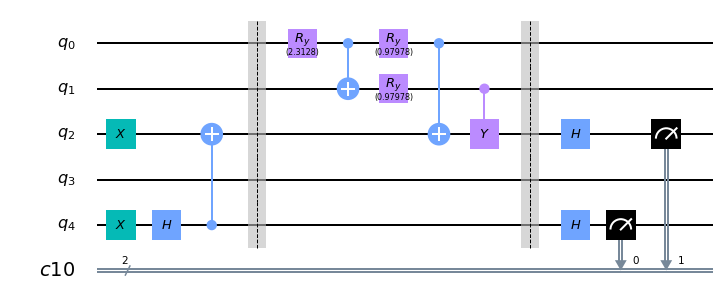

In [7]:
circuits['tan'][1.0][0].draw(output='mpl')

Drawing of one of the circuits, with the measurement on the `(X, X)` basis.

### 2. Simulation <a id="simulation"/>

This cell executes locally the (noiseless) simulation of the circuits above.

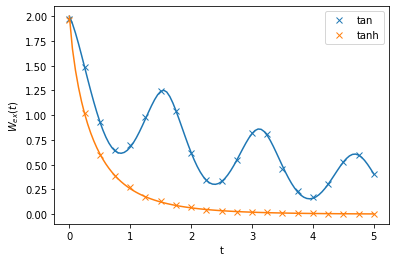

In [47]:
from extractable_work import extractable_work
theor_tanh = json.load(open("wex_tanh.dat"))
theor_tan = json.load(open("wex_tan.dat"))

for label, circs in tqdm(circuits.items(), leave=False):
    wext = []
    for t, tomo_circuits in tqdm(circs.items(), leave=False):
        job = execute(tomo_circuits, backend=simulator, shots=SHOTS)
        result = job.result()
        tomo_fitter = StateTomographyFitter(result, tomo_circuits)
        rho = tomo_fitter.fit()
        wext.append(extractable_work(rho, 1, 0))

    plt.plot(list(circs.keys()), wext, 'x', label=label)

plt.plot(theor_tan['t'], theor_tan['w_ex'], 'C0')
plt.plot(theor_tanh['t'], theor_tanh['w_ex'], 'C1')

plt.xlabel('t')
plt.ylabel('$W_{ex}(t)$')
plt.legend();

### 3. Execution on the real device <a id="execution" />


> **NOTE:** At the moment, this division of circuits in jobs is not efficient, and 42 jobs are required. A normal IBM Q account only allows for 5 jobs to be queued at the same time, hence extra credits need to be requested to IBM.
The circuits can be rearranged in a smarter way (up to 75 per job) to minimize the number of jobs.

In [44]:
# Run the calibration job
cal_circuits, state_labels = complete_meas_cal([system, ancilla], q, c)
calibration_job = execute(cal_circuits, backend, shots=SHOTS)

experiments = {'tan': {
                    "backend": backend.name(),
                    "calibration": calibration_job.job_id(),
                    "description": "tan",
                    "jobs": [],
                    "metadata": params_tan
                }, 
               'tanh': {
                    "backend": backend.name(),
                    "calibration": calibration_job.job_id(),
                    "description": "tanh",
                    "jobs": [],
                    "metadata": params_tanh
                }
              }

for label, circs in tqdm(circuits.items(), leave=False):
    wext = []
    for t, tomo_circuits in tqdm(circs.items(), leave=False):
        job = execute(tomo_circuits, backend=backend, shots=SHOTS)
        experiments[label]['jobs'].append({'jobid': job.job_id(), 'description': "Two-qubit tomography circuits", 'metadata': {'t': t}})        

experiment_data = list(experiments.values())
        
filename = 'pauli_channel_work_extraction_{}.json'.format(
            datetime.now().strftime(("%Y_%m_%d-%H_%M")))

with open(filename,'w') as file:
    json.dump(experiment_data, file)

All the information about the experiment is stored in a JSON file called `pauli_channel_work_extraction_DATETIME.json`.

### 4. Analysis of the results <a id="analysis"/>
#### Instructions:
Use the `filename` variable to load the JSON file containing the experiment information

In [48]:
# List the available experiment files

import glob

print("Available experiment files:")
for f in glob.glob('*.json'):
    print(f)

Available experiment files:
pauli_channel_work_extraction_2019_10_11-16_36.json
pauli_channel_work_extraction_2019_10_11-16_09.json


In [61]:
filename = "pauli_channel_work_extraction_2019_10_11-16_36.json"

with open(filename, 'r') as file:
    experiment_data = json.load(file)

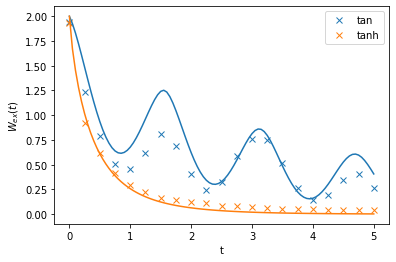

In [91]:
from extractable_work import extractable_work
theor_tanh = json.load(open("wex_tanh.dat"))
theor_tan = json.load(open("wex_tan.dat"))

for experiment in tqdm(experiment_data, leave=False):
    backend = IBMQ.get_provider().get_backend(experiment['backend'])
    
    # Use the calibration job to implement the error mitigation
    calibration_job = backend.retrieve_job(experiment['calibration'])
    if calibration_job.status() == JobStatus.DONE:
        meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)
        meas_filter = meas_fitter.filter

        label = experiment['description']
        t = []
        wext = []
        for jobdata in tqdm(experiment['jobs'], leave=False):
            job = backend.retrieve_job(jobdata['jobid'])
            if job.status() == JobStatus.DONE:
                result = job.result()
                result = meas_filter.apply(result)
                
                tomo_circuits = disassemble(job.qobj())[0]
                tomo_fitter = StateTomographyFitter(result, tomo_circuits)
                rho = tomo_fitter.fit()
                
                t.append(jobdata['metadata']['t'])
                wext.append(extractable_work(rho, 1, 0))
            else:
                break

    plt.plot(t, wext, 'x', label=label)

plt.plot(theor_tan['t'], theor_tan['w_ex'], 'C0')
plt.plot(theor_tanh['t'], theor_tanh['w_ex'], 'C1')

plt.xlabel('t')
plt.ylabel('$W_{ex}(t)$')
plt.legend();

The job contains info on the gate and measurement error rates

In [93]:
job.properties().qubits

[[Nduv(date=datetime.datetime(2019, 10, 10, 8, 48, 19, tzinfo=tzutc()), name='T1', unit='µs', value=74.85208690842674),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 49, 59, tzinfo=tzutc()), name='T2', unit='µs', value=63.00239136127134),
  Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='frequency', unit='GHz', value=5.286310100364124),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 46, 51, tzinfo=tzutc()), name='readout_error', unit='', value=0.011500000000000066),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 46, 51, tzinfo=tzutc()), name='prob_meas0_prep1', unit='', value=0.015000000000000013),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 46, 51, tzinfo=tzutc()), name='prob_meas1_prep0', unit='', value=0.008)],
 [Nduv(date=datetime.datetime(2019, 10, 10, 8, 48, 19, tzinfo=tzutc()), name='T1', unit='µs', value=55.91509286343368),
  Nduv(date=datetime.datetime(2019, 10, 10, 8, 51, 50, tzinfo=tzutc()), name='T2', unit='µs', value=49.94183738916608),
  Nd

In [94]:
job.properties().gates

[Gate(gate='id', name='id_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.000530003638190013), Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u1', name='u1_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0), Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='gate_length', unit='ns', value=0.0)], qubits=[0]),
 Gate(gate='u2', name='u2_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.000530003638190013), Nduv(date=datetime.datetime(2019, 10, 10, 9, 50, 37, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u3', name='u3_0', parameters=[Nduv(date=datetime.datetime(2019, 10, 10, 8, 55, 41, tzinfo